In [1]:
from requests import get
from bs4 import BeautifulSoup
from datetime import date, timedelta
from time import sleep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'https://www.worldometers.info/coronavirus/'
timestamp = (date.today() - timedelta(days=1)).strftime("%Y-%m-%d")
_dict = {}
save_csv = True
append_csv = False
percentile = 97

In [3]:
page = get(url).content
soup = BeautifulSoup(page)

In [4]:
_div_list = soup.find_all('div')
for _div in _div_list:
    for _attr in _div.attrs:
        if _attr == 'id':
            # Aseguramos que los datos son los últimos disponibles para el día,
            # utilizando los datos de ayer
            if _div['id'] == 'nav-yesterday':
                for _tr_list in _div.tbody.find_all('tr'):
                    _td_list = _tr_list.find_all('td')
                    for i, _td in enumerate(_td_list):  
                        # Recuperar el nombre del pais cuando es un enlace
                        if i%10 == 0:
                            _a = _td.find('a')
                            # Recuperar el nombre del pais cuando es un enlace
                            if _a:
                                country_name = _a['href'].split('/')[1]
                            else:
                                _span = _td.find('span')
                                if _span:
                                    # Recuperar el nombre del cuando ocupa dos filas
                                    country_name = _span.contents[0]
                                else:
                                     # Recuperar el nombre del pais cuando no es un enlace
                                    country_name = _td.contents[0]
                            if country_name:
                                country_name = country_name.strip()
                                if country_name not in list(_dict.keys()):
                                    _dict[country_name] = {} 
                                _dict[country_name][timestamp] = []
                        # Recuperar los datos del pais
                        else:
                            if len(_td.contents) > 0:
                                # Limipiar el dato de cualquier símbolo para poder convertirlo en un valor numérico
                                data = _td.contents[0].replace('+','').replace(',','').strip()
                                if data:
                                    _dict[country_name][timestamp].append(float(data))
                                else:
                                    _dict[country_name][timestamp].append(0)
                            else:
                                _dict[country_name][timestamp].append(0)          

In [5]:
# https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
df = pd.concat({k: pd.DataFrame(v).T for k, v in _dict.items()}, axis=0)
df.columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_recovered', 'active_cases', 'servious_critical', 'total_cases_1M_pop', 'total_deaths_1M_pop']
df.index.names = ['country', 'date']
display(df.head())

total_cases  new_cases  total_deaths  \
country             date                                               
Afghanistan         2020-03-24         74.0       34.0           1.0   
Albania             2020-03-24        123.0       19.0           5.0   
Andorra             2020-03-24        164.0       31.0           1.0   
Angola              2020-03-24          3.0        0.0           0.0   
Antigua and Barbuda 2020-03-24          3.0        0.0           0.0   

                                new_deaths  total_recovered  active_cases  \
country             date                                                    
Afghanistan         2020-03-24         0.0              1.0          72.0   
Albania             2020-03-24         1.0             10.0         108.0   
Andorra             2020-03-24         0.0              1.0         162.0   
Angola              2020-03-24         0.0              0.0           3.0   
Antigua and Barbuda 2020-03-24         0.0              0.0           3.0   

                                servious_critical  total_cases_1M_pop  \
country             date                                                
Afghanistan         2020-03-24                0.0                2.00   
Albania             2020-03-24                2.0               43.00   
Andorra             2020-03-24                7.0             2123.00   
Angola              2020-03-24                0.0                0.09   
Antigua and Barbuda 2020-03-24                0.0               31.00   

                                total_deaths_1M_pop  
country             date                             
Afghanistan         2020-03-24                 0.03  
Albania             2020-03-24                 2.00  
Andorra             2020-03-24                13.00  
Angola              2020-03-24                 0.00  
Antigua and Barbuda 2020-03-24                 0.00

In [6]:
if save_csv:
    if append_csv:
        print('Adding data to csv...')
        df.to_csv('covid-19_2020.csv', mode='a', header=False, index=True) 
    else:
        print('Creating csv...')
        df.to_csv('covid-19_2020.csv', index=True)    
else:
    print('Save csv not needed')

Creating csv...


In [7]:
df = pd.read_csv('covid-19_2020.csv')

In [8]:
df.head()

country        date  total_cases  new_cases  total_deaths  \
0          Afghanistan  2020-03-24         74.0       34.0           1.0   
1              Albania  2020-03-24        123.0       19.0           5.0   
2              Andorra  2020-03-24        164.0       31.0           1.0   
3               Angola  2020-03-24          3.0        0.0           0.0   
4  Antigua and Barbuda  2020-03-24          3.0        0.0           0.0   

   new_deaths  total_recovered  active_cases  servious_critical  \
0         0.0              1.0          72.0                0.0   
1         1.0             10.0         108.0                2.0   
2         0.0              1.0         162.0                7.0   
3         0.0              0.0           3.0                0.0   
4         0.0              0.0           3.0                0.0   

   total_cases_1M_pop  total_deaths_1M_pop  
0                2.00                 0.03  
1               43.00                 2.00  
2             2123.00                13.00  
3                0.09                 0.00  
4               31.00                 0.00

In [9]:
# Solo paises más significativos
df_significant = df[(df['total_cases'] > np.percentile(df['total_cases'], percentile))].sort_values(by = ['date', 'total_cases'], ascending=False)

# Se muestra el número de casos según el país ("country") para la última muestra
last_date = list(df_significant['date'])[0]
df_last_date = df_significant[(df_significant['date'] == last_date)]
display(df_last_date)

country        date  total_cases  new_cases  total_deaths  new_deaths  \
172    china  2020-03-24      81171.0       78.0        3277.0         7.0   
182    italy  2020-03-24      69176.0     5249.0        6820.0       743.0   
194       us  2020-03-24      54856.0    11075.0         780.0       225.0   
190    spain  2020-03-24      42058.0     6922.0        2991.0       680.0   
176  germany  2020-03-24      32991.0     3935.0         159.0        36.0   
179     iran  2020-03-24      24811.0     1762.0        1934.0       122.0   

     total_recovered  active_cases  servious_critical  total_cases_1M_pop  \
172          73159.0        4735.0             1573.0                56.0   
182           8326.0       54030.0             3393.0              1144.0   
194            379.0       53697.0             1175.0               166.0   
190           3794.0       35273.0             2636.0               900.0   
176           3290.0       29542.0               23.0               394.0   
179           8913.0       13964.0                0.0               295.0   

     total_deaths_1M_pop  
172                  2.0  
182                113.0  
194                  2.0  
190                 64.0  
176                  2.0  
179                 23.0

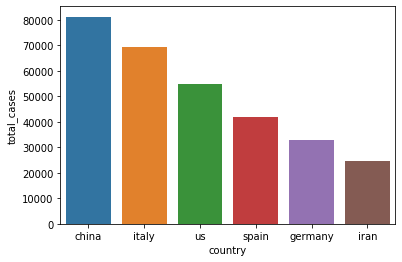

In [10]:
# Se representan gráficamente los resultados
# https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot
plot = sns.barplot(x="country", y="total_cases", data=df_last_date)

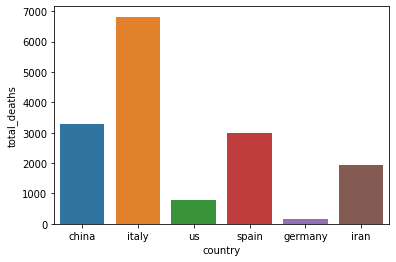

In [11]:
plot = sns.barplot(x="country", y="total_deaths", data=df_last_date)

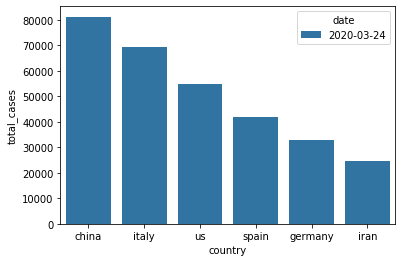

In [12]:
# Se muestra la evolución en el tiempo para cada país ("country")
# Se representan gráficamente los resultados
# 
plot = sns.barplot(x="country", y="total_cases", hue = "date", data=df_significant)

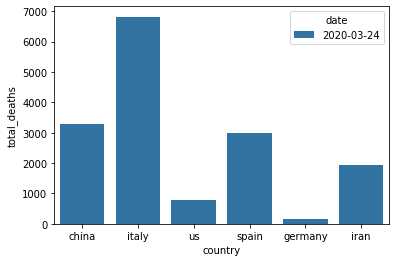

In [13]:
plot = sns.barplot(x="country", y="total_deaths", hue = "date", data=df_significant)

In [14]:
df_spain = df_significant[(df_significant['country'] == 'spain')]

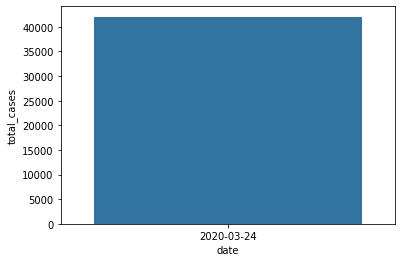

In [15]:
plot = sns.barplot(x='date', y="total_cases", data=df_spain)

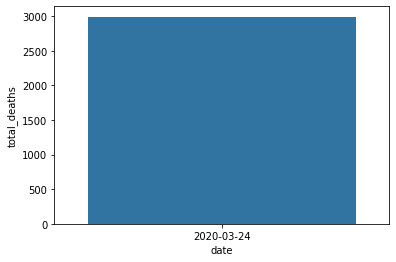

In [16]:
plot = sns.barplot(x='date', y="total_deaths", data=df_spain)